In [1]:
import pandas as pd
import pickle
import numpy as np

from tqdm import tqdm

In [2]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

DATA_PATH = '/opt/ml/input/data/train_dataset/test_data.csv'
test_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [3]:
test_df.head(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
5,3,A050023007,A050000023,0,2020-01-09 10:58:46,2623
6,3,A050023005,A050000023,0,2020-01-09 10:59:11,192
7,3,A050027001,A050000027,0,2020-01-13 12:56:55,3691
8,3,A050027002,A050000027,0,2020-01-13 12:59:26,3691
9,3,A050027003,A050000027,0,2020-01-13 13:00:29,3682


## time delta 계산

In [4]:
def get_timedelta(df):
    diff = df.loc[:, ['userID', 'Timestamp', 'testId']].groupby(['userID','testId']).diff().shift(-1).fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    return diff

In [5]:
diff = get_timedelta(test_df)
diff = diff.rename('elapsed')
diff.head()

0    26.0
1    94.0
2     5.0
3     7.0
4     3.0
Name: elapsed, dtype: float64

## 결측치 파악

<AxesSubplot:ylabel='Frequency'>

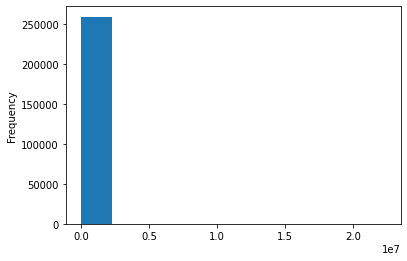

In [6]:
diff.plot.hist()

In [7]:
# pure 하게 문제 푼 시간 아니라고 판단

threshold_minutes = 10

too_long = diff[diff > threshold_minutes * 60]
print(len(too_long))
too_long.head()

4351


16         674.0
135    3178322.0
177       2203.0
277     199748.0
284    7245645.0
Name: elapsed, dtype: float64

In [8]:
# 너무 긴 time delta 는 0 으로 초기화하고 뒤에서 통계량으로 대체한다
diff[diff > threshold_minutes * 60] = 0

<AxesSubplot:ylabel='Frequency'>

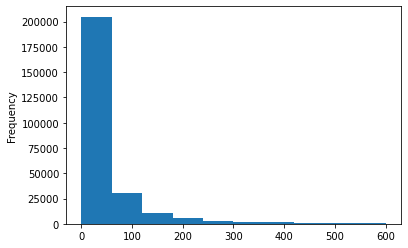

In [9]:
test_df['elapsed'] = diff
test_df['elapsed'].plot.hist()


In [10]:
def nonzero_mean(s):
    if isinstance(s, pd.Series):
        s = s.to_numpy()
    elif isinstance(s, list):
        s = np.array(s)
        
    num_nonzero = len(s.nonzero()[0])

    if num_nonzero == 0:
        return 0

    return np.sum(s) / num_nonzero

## Train data, test data 간 겹치는 부분

In [64]:
DATA_PATH = '/opt/ml/input/data/train_dataset/train_timedelta_replaced.csv'
train_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
train_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0


In [74]:
train_questions = set(train_df['assessmentItemID'].unique())
train_tags = set(train_df['assessmentItemID'].unique())
train_users = set(train_df['userID'].unique())

test_questions = set(test_df['assessmentItemID'].unique())
test_tags = set(test_df['assessmentItemID'].unique())
test_users = set(test_df['userID'].unique())


- User 는 겹치지 않음
- KnowledgeTag, assessmentItemID 는 동일하므로 통계량 계산에 사용

In [75]:
print(len(train_questions & test_questions))
print(len(train_tags & test_tags))
print(len(train_users & test_users))

9454
9454
0


## answerCode == -1 인 데이터에 대해

In [55]:
pred_targets = test_df[test_df['answerCode'] == -1]
non_pred_targets = test_df[test_df['answerCode'] != -1]

pred_targets.head()


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
1035,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,0.0
1706,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,0.0
3023,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,0.0
4283,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,0.0
4670,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,0.0


In [63]:
# 참고할만한 다른 데이터가 매우 적어서 충분히 represent 못함

non_pred_targets[(non_pred_targets['assessmentItemID'] == 'A090064006') & (non_pred_targets['elapsed'] != 0)].head(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
26345,355,A090064006,A090000064,1,2020-11-23 02:28:10,2611,255.0


In [26]:
pred_target_tags = set(pred_targets['KnowledgeTag'].unique())
print(len(pred_target_tags))

273


In [27]:
non_pred_targets = test_df[test_df['answerCode'] != -1]
non_pred_target_questions = set(non_pred_targets['assessmentItemID'].unique())
non_pred_target_tags = set(non_pred_targets['KnowledgeTag'].unique())


## 결측치 대체에 사용할 함수들

In [11]:
# Use both train, test dataset with nonzero elapsed to calculate mean
DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
raw_train_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
raw_train_df = raw_train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

DATA_PATH = '/opt/ml/input/data/train_dataset/test_data.csv'
raw_test_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
raw_test_df = raw_test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

full_df = pd.concat([raw_train_df, raw_test_df], ignore_index=True)
full_df = full_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [12]:
full_df_diff = get_timedelta(full_df)

In [13]:
full_df_diff[full_df_diff > threshold_minutes * 60] = 0
full_df['elapsed'] = full_df_diff

In [14]:
full_df = full_df[full_df['elapsed'] != 0]
print(len(full_df))

2065933


In [15]:
# 동일 assessmentItemID 에서 다른 사용자가 걸린 시간
def get_time_per_question(df, answer=True):
    groupby_key = ['assessmentItemID', 'answerCode']
    if not answer:
        # answerCode == -1 인 경우 정답, 오답 모두의 시간을 평균냄
        groupby_key = groupby_key[:-1]
    tag_groupby = df.groupby(groupby_key).agg({
        'elapsed': nonzero_mean
    })

    return groupby_key, tag_groupby

In [16]:
# 동일 사용자, knowledgeTag 에서 걸린 시간
def get_time_per_user_tag(df, answer=True):
    groupby_key = ['userID', 'KnowledgeTag', 'answerCode']
    if not answer:
        # answerCode == -1 인 경우 정답, 오답 모두의 시간을 평균냄
        groupby_key = groupby_key[:-1]
    tag_groupby = df.groupby(groupby_key).agg({
        'elapsed': nonzero_mean
    })

    return groupby_key, tag_groupby

In [17]:
# 동일 KnowledgeTag 에서 다른 사용자가 걸린 시간
def get_time_per_tag(df, answer=True):
    groupby_key = ['KnowledgeTag', 'answerCode']
    if not answer:
        # answerCode == -1 인 경우 정답, 오답 모두의 시간을 평균냄
        groupby_key = groupby_key[:-1]
    tag_groupby = df.groupby(groupby_key).agg({
        'elapsed': nonzero_mean
    })

    return groupby_key, tag_groupby

In [16]:
# 동일 사용자, 정답에서 걸린 시간
# warning: not a good representation :(
# def get_time_per_user(df):
#     user_groupby = df.groupby(['userID', 'answerCode']).agg({
#         'elapsed': nonzero_mean
#     })

#     return user_groupby

In [40]:
key, r = get_time_per_question(full_df, answer=False)
print(key)
r.head()

['assessmentItemID']


,elapsed
assessmentItemID,
A010001001,25.994269
A010001002,17.471264
A010001003,40.982709
A010001004,50.645533
A010001005,90.666667


In [53]:
r['elapsed'][('A070163008',)]

KeyError: 'key of type tuple not found and not a MultiIndex'

## 결측치 대체하기

In [57]:
def replace_zeros(unresolved, rep_func):

    key, r = rep_func(full_df)
    _, r_noanswer = rep_func(full_df, answer=False)

    for index, row in tqdm(unresolved.iterrows()):
        # Get replacement
        # Key tuple 을 이루는 item 들 list 에 담고 tuple 화

        rep_key = []
        for k in key:
            tmp = row[k]
            if k in ['userID', 'KnowledgeTag', 'answerCode']:
                tmp = int(tmp)
            rep_key.append(tmp)

        answer = int(row['answerCode'])

        # rep_same_answer = tuple(rep_key + [answer % 2])
        # rep_diff_answer = tuple(rep_key + [(answer+1) % 2])

        if answer == -1:
            # groupby key 에서 answerCode 삭제
            rep_key = tuple(rep_key[:-1])

            if len(rep_key) == 1:
                # Trailing comma leads to invalid key
                rep_key = rep_key[0]
            replace_elapsed = r_noanswer['elapsed'].get(rep_key, 0)
            # print(rep_key, index, replace_elapsed)
        else:
            rep_key = tuple(rep_key)
            replace_elapsed = r['elapsed'].get(rep_key, 0)

        if replace_elapsed > 0:
            unresolved.at[index, ['elapsed']] = (replace_elapsed)

    return unresolved

In [58]:
zeros = test_df[test_df['elapsed'] == 0]
print(len(zeros))

47251


In [59]:
unresolved = replace_zeros(zeros, get_time_per_question)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
47251it [01:14, 630.78it/s]


In [60]:
zeros.update(unresolved)
unresolved = zeros[zeros['elapsed'] == 0]
print(len(unresolved))

2558
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [61]:
unresolved = replace_zeros(unresolved, get_time_per_user_tag)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
2558it [00:03, 725.64it/s]


In [62]:
zeros.update(unresolved)
unresolved = zeros[zeros['elapsed'] == 0]
print(len(unresolved))

307
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [63]:
unresolved = replace_zeros(unresolved, get_time_per_tag)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
307it [00:00, 554.84it/s]


In [64]:
zeros.update(unresolved)
unresolved = zeros[zeros['elapsed'] == 0]
print(len(unresolved))

0
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [67]:
test_df.update(zeros)
# Verify all zeros are filled
print(len(test_df[test_df['elapsed'] == 0]))

0


In [68]:
test_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,3.0,A050023001,A050000023,1.0,2020-01-09 10:56:31,2626.0,26.0
1,3.0,A050023002,A050000023,1.0,2020-01-09 10:56:57,2626.0,94.0
2,3.0,A050023003,A050000023,0.0,2020-01-09 10:58:31,2625.0,5.0
3,3.0,A050023004,A050000023,0.0,2020-01-09 10:58:36,2625.0,7.0
4,3.0,A050023006,A050000023,0.0,2020-01-09 10:58:43,2623.0,3.0


In [69]:
# 형변환
test_df['userID'] = test_df['userID'].astype(int)
test_df['answerCode'] = test_df['answerCode'].astype(int)
test_df['KnowledgeTag'] = test_df['KnowledgeTag'].astype(int)
test_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,26.0
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,94.0
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,5.0
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,7.0
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,3.0


In [70]:
test_df.to_csv('/opt/ml/input/data/train_dataset/test_timedelta_replaced_2.csv', sep=',', index=False)

## Train data 도 비슷한 방법으로 결측치 대체

In [71]:
DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
train_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
train_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [72]:
diff = get_timedelta(train_df)
diff = diff.rename('elapsed')
diff.head()

0     3.0
1     8.0
2     7.0
3     7.0
4    11.0
Name: elapsed, dtype: float64

In [74]:
diff[diff > threshold_minutes * 60] = 0

train_df['elapsed'] = diff
train_df.head(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,0.0
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,7.0
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,64.0
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,15.0
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,19.0


In [75]:
zeros = train_df[train_df['elapsed'] == 0]
print(len(zeros))

413516


In [76]:
unresolved = replace_zeros(zeros, get_time_per_question)

1it [00:02,  2.23s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
413516it [21:47, 316.23it/s]


In [77]:
zeros.update(unresolved)
unresolved = zeros[zeros['elapsed'] == 0]
print(len(unresolved))

22852
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [78]:
unresolved = replace_zeros(unresolved, get_time_per_user_tag)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
22852it [00:31, 727.70it/s]


In [79]:
zeros.update(unresolved)
unresolved = zeros[zeros['elapsed'] == 0]
print(len(unresolved))

2926
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [80]:
unresolved = replace_zeros(unresolved, get_time_per_tag)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
2926it [00:04, 693.17it/s]


In [81]:
zeros.update(unresolved)
unresolved = zeros[zeros['elapsed'] == 0]
print(len(unresolved))

0
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [82]:
train_df.update(zeros)
# Verify all zeros are filled
print(len(train_df[train_df['elapsed'] == 0]))

0


In [83]:
train_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0.0,A060001001,A060000001,1.0,2020-03-24 00:17:11,7224.0,3.0
1,0.0,A060001002,A060000001,1.0,2020-03-24 00:17:14,7225.0,8.0
2,0.0,A060001003,A060000001,1.0,2020-03-24 00:17:22,7225.0,7.0
3,0.0,A060001004,A060000001,1.0,2020-03-24 00:17:29,7225.0,7.0
4,0.0,A060001005,A060000001,1.0,2020-03-24 00:17:36,7225.0,11.0


In [84]:
# 형변환
train_df['userID'] = train_df['userID'].astype(int)
train_df['answerCode'] = train_df['answerCode'].astype(int)
train_df['KnowledgeTag'] = train_df['KnowledgeTag'].astype(int)
train_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0


In [85]:
train_df.to_csv('/opt/ml/input/data/train_dataset/train_timedelta_replaced_2.csv', sep=',', index=False)